## Objective 1 - Apply linear svm and logistic regression on TFIDF vectorizer
## Objective 2 - Hyperparameter Tune XGBOOST on TFIDF vectorizer

In [5]:
# Importing neccesary packages
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import scipy
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV


from scipy.stats import randint as sp_randint

In [6]:
# utility functions
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

## DATASET PREPRATION

In [7]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [8]:
# dropping only qid1, qid1 from the advanced features
df1 = dfnlp.drop(['qid1','qid2',],axis=1)
# dropping only qid1 , qid2, question1, question2 from the advanced features
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

# so finaldf_all = 19columns(df1) + 12columns(df2) = 31 columns

In [9]:
df1.head(2)

,id,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [10]:
df2.head(2)

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


In [11]:
# joining advancedfeatures(df1) and normalfeatures(df2) taking index in common id
finaldf_all = df1.join(df2.set_index('id'), on='id')

In [12]:
finaldf_all.shape

(404290, 30)

In [13]:
finaldf_all.head(2)

,id,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,...,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,...,1,51,88,8,13,4.0,20.0,0.200000,5,3


In [14]:
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
finaldf_all['question1'] = finaldf_all['question1'].apply(lambda x: str(x))
finaldf_all['question2'] = finaldf_all['question2'].apply(lambda x: str(x))

In [15]:
print(finaldf_all['is_duplicate'].value_counts())
print('Percentage of class 0 / class 1 = ',sum(finaldf_all['is_duplicate']==0)/sum(finaldf_all['is_duplicate']==1))

0    255027
1    149263
Name: is_duplicate, dtype: int64
Percentage of class 0 / class 1 =  1.708574797505075


In [16]:
# Sampling 100k data points for the model
finaldf_100k = finaldf_all.sample(n=100000,random_state = 1)
print(finaldf_100k.shape)

(100000, 30)


In [17]:
print(finaldf_100k['is_duplicate'].value_counts())
print('Percentage of class 0 / class 1 = ',sum(finaldf_100k['is_duplicate']==0)/sum(finaldf_100k['is_duplicate']==1))

0    63062
1    36938
Name: is_duplicate, dtype: int64
Percentage of class 0 / class 1 =  1.7072391575071741


In [18]:
# taking actual label from dataset(100k)
y_true = finaldf_100k['is_duplicate']

In [19]:
y_true = list(map(int, y_true.values))

In [20]:
# randomly sampling 70% to train and 30% to test dataset
X_train,X_test, y_train, y_test = train_test_split(finaldf_100k, y_true, stratify=y_true, test_size=0.3)

In [21]:
print('Data Points ::-\n')
print('** Train Data **')
print(X_train.shape)

print('\n')
print('** Test Data **')
print(X_test.shape)


Data Points ::-

** Train Data **
(70000, 30)


** Test Data **
(30000, 30)


In [22]:
import numpy as np
y_train=np.asarray(y_train)
y_train.shape


(70000,)

## TFIDF VECTORIZER

In [23]:
from sklearn.preprocessing import StandardScaler

In [24]:
# storing length of actual label from train and test dataset
test_len = len(y_test)
train_len = len(y_train)

In [22]:
questions = list(X_train['question1']) + list(X_train['question2'])

tfidf = TfidfVectorizer(lowercase=False, )

tfidf.fit_transform(questions)


# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [23]:
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [24]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_train['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)


100%|████████████████████████████████████████████████████████████████████████████| 70000/70000 [27:12<00:00, 45.68it/s]


In [25]:
X_train['q1_feats_m1'] = list(vecs1)

In [26]:
vecs2 = []
for qu2 in tqdm(list(X_train['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
X_train['q2_feats_m2'] = list(vecs2)

100%|████████████████████████████████████████████████████████████████████████████| 70000/70000 [27:17<00:00, 42.75it/s]


In [27]:
questions1 = list(X_test['question1']) + list(X_test['question2'])
tfidf2=tfidf.transform(questions1)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [28]:
# en_vectors_web_lg, which includes o
vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_test['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_test['q1_feats_m1'] = list(vecs1)
            

100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [11:37<00:00, 43.03it/s]


In [29]:
vecs2 = []
for qu2 in tqdm(list(X_test['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
X_test['q2_feats_m2'] = list(vecs2)

100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [11:42<00:00, 42.70it/s]


In [30]:
X_train.head(1)

,id,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,...,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,q1_feats_m1,q2_feats_m2
74115,74115,which is the biggest mountain in world,what is the highest point on earth,0,0.0,0.0,0.499988,0.499988,0.28571,0.28571,...,34,7,6,1.0,13.0,0.076923,5,3,"[28.342119693756104, -65.65542232990265, -3.30...","[25.59434962272644, -40.51456779241562, 4.8555..."


In [88]:
X_test.shape

(30000, 32)

In [31]:
df3_train_q1 = pd.DataFrame(X_train.q1_feats_m1.values.tolist(), index=X_train.index)
df3_train_q2 = pd.DataFrame(X_train.q2_feats_m2.values.tolist(), index=X_train.index)
df3_test_q1 = pd.DataFrame(X_test.q1_feats_m1.values.tolist(), index= X_test.index)
df3_test_q2 = pd.DataFrame(X_test.q2_feats_m2.values.tolist(), index= X_test.index)

In [32]:
df3_train_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
74115,28.342120,-65.655422,-3.305757,-36.221644,-15.758525,2.656343,41.722423,-16.573237,3.352089,58.114413,...,76.761795,-42.963629,10.891767,-16.339794,-51.902172,46.338237,-76.505950,-37.794047,-18.191391,10.335420
277490,30.276163,-29.325949,-61.178077,-81.740502,-96.564239,29.285613,112.507527,37.386202,-37.308594,27.751824,...,32.825015,-15.220842,50.277617,29.741376,24.410815,-6.029410,-17.931044,50.633879,-42.181083,35.140881
20091,46.839867,3.725437,-24.829658,-32.667083,-59.594472,12.358915,-16.538389,12.188280,-6.156457,17.550720,...,13.756448,-40.536666,38.169990,42.626889,18.760250,-18.489666,91.705598,-7.827854,23.499677,-7.382498
190480,85.900185,-74.355662,-116.530410,-118.997691,-66.737161,191.491136,381.098036,127.951849,-52.777224,-13.289718,...,97.241954,-37.642125,134.624104,-29.470691,10.633374,-63.427547,-141.493477,1.157382,-100.651007,-10.794596
198221,83.347685,-63.665868,-20.677916,-35.722918,-84.458409,53.558986,86.763730,45.934571,-94.950550,38.320062,...,96.513317,-80.449938,51.248447,102.759328,26.712866,43.789794,-14.892993,57.219573,-75.600441,62.430481


In [89]:
df3_test_q1.shape

(30000, 97)

In [90]:
df3_train_q1['id']=X_train['id']
df3_train_q2['id']=X_train['id']
df3_test_q1['id']=X_test['id']
df3_test_q2 ['id']=X_test['id']

In [34]:
 df3_train_q1= df3_train_q1.drop(['question1_x','question2_x','is_duplicate_x'], axis=1, inplace=False)
df3_train_q2 = df3_train_q2.drop(['question1_x','question2_x','is_duplicate_x'], axis=1, inplace=False)
df3_test_q1= df3_train_q1.drop(['question1_x','question2_x','is_duplicate_x'], axis=1, inplace=False)
df3_test_q2 = df3_train_q1.drop(['question1_x','question2_x','is_duplicate_x'], axis=1, inplace=False)


KeyError: "['question1_x' 'question2_x' 'is_duplicate_x'] not found in axis"

In [91]:
df3_test_q1.shape

(30000, 97)

In [92]:
df1 = X_train.merge(df3_train_q1, on='id',how='left')
df2  = df3_train_q2
result  = df1.merge(df2, on='id',how='left')

In [48]:
result.columns

Index(['id', 'question1', 'question2', 'is_duplicate', 'cwc_min', 'cwc_max',
       'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       ...
       '86_y', '87_y', '88_y', '89_y', '90_y', '91_y', '92_y', '93_y', '94_y',
       '95_y'],
      dtype='object', length=224)

In [95]:
df3 = X_test.merge(df3_test_q1, on='id',how='left')
df4  = df3_test_q2
result2  = df3.merge(df4, on='id',how='left')

In [96]:
result2.shape

(30000, 224)

In [97]:
# Dropping id and questions from the dataset after tfidf vectorizing the data
train_feature_df = result.drop(['id','question1','question2','is_duplicate',], axis=1, inplace=False)
test_feature_df = result2.drop(['id','question1','question2','is_duplicate'], axis=1, inplace=False)

In [98]:
# Dropping id and questions from the dataset after tfidf vectorizing the data
train_feature_df = train_feature_df.drop(['q1_feats_m1','q2_feats_m2',], axis=1, inplace=False)
test_feature_df = test_feature_df.drop(['q1_feats_m1','q2_feats_m2'], axis=1, inplace=False)

In [99]:
test_feature_df.shape

(30000, 218)

In [101]:
X_train=train_feature_df
X_test= test_feature_df

In [62]:
# storing the final features to csv file
if not os.path.isfile('train_feature_df_3.csv'):
    train_feature_df.to_csv('train_feature_df_3.csv')

In [78]:
cols = list(train_feature_df.columns)
for i in cols:
    train_feature_df[i] = train_feature_df[i].apply(pd.to_numeric)
    print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x


KeyboardInterrupt: 

In [ ]:
print(type(train_feature_df ))
print(type(train_feature_df ))

In [87]:
print(train_feature_df.shape)
print(test_feature_df.shape)
print(type(train_feature_df['cwc_min_x'][0]))


(70000, 218)
(70000, 218)


KeyError: 'cwc_min_x'

In [ ]:
test_feature_df.head()

In [43]:
import numpy
train_feature_df1=numpy.array(train_feature_df, dtype=object)

In [ ]:
if os.path.isfile('final_features_train.csv'):
    train_q1q2 = pd.read_csv("final_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('final_features_test.csv'):
    test_q1q2 = pd.read_csv("final_features_test.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [ ]:
train_q1q2 = train_q1q2.drop(['Unnamed: 0','question1_y','question2_y','is_duplicate_y'], axis=1, inplace=False)
test_q1q2 = test_q1q2.drop(['Unnamed: 0','question1_y','question2_y','is_duplicate_y'], axis=1, inplace=False)

In [ ]:
train_q1q2 = train_q1q2.drop(['Unnamed: 0'], axis=1, inplace=False)
test_q1q2 = test_q1q2.drop(['Unnamed: 0'], axis=1, inplace=False)

In [ ]:
import numpy
train_q1q2_1 = numpy.array(train_q1q2, dtype=float)
test_q1q2_1 = numpy.array(test_q1q2, dtype=float)

In [ ]:
cols = list(train_q1q2.columns)
for i in cols:
    train_q1q2[i] = train_q1q2[i].apply(pd.to_numeric)
    print(i)

## RANDOM MODEL

Log loss on Test Data using Random Model 0.8858399387086345


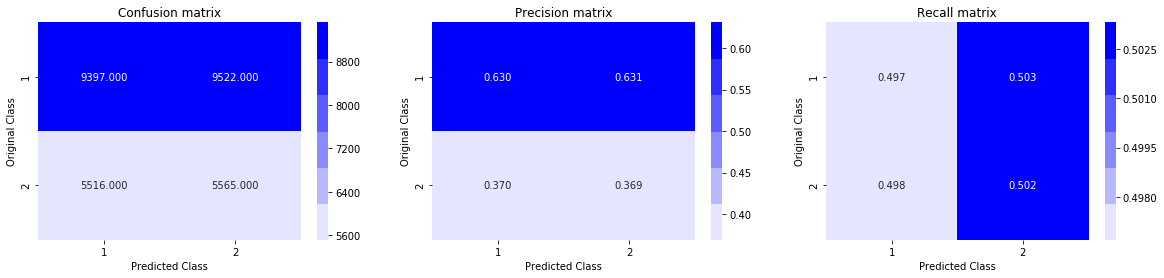

In [25]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
import numpy as np
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

## LOGISTIC REGRESSION

For values of alpha =  1e-05 The log loss is: 0.5377998174281806
For values of alpha =  0.0001 The log loss is: 0.5394625836888048
For values of alpha =  0.001 The log loss is: 0.5367238647169592
For values of alpha =  0.01 The log loss is: 0.5415005240252039
For values of alpha =  0.1 The log loss is: 0.542652535749778
For values of alpha =  1 The log loss is: 0.5315826468703193
For values of alpha =  10 The log loss is: 0.5405849976293833


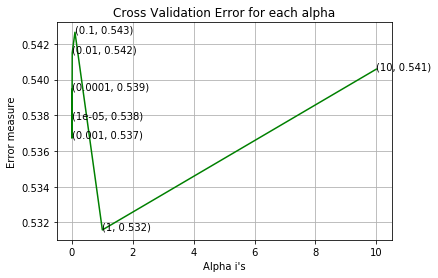

For values of best alpha =  1 The train log loss is: 0.5196308108040604
For values of best alpha =  1 The test log loss is: 0.5315826468703193
Total number of data points : 30000


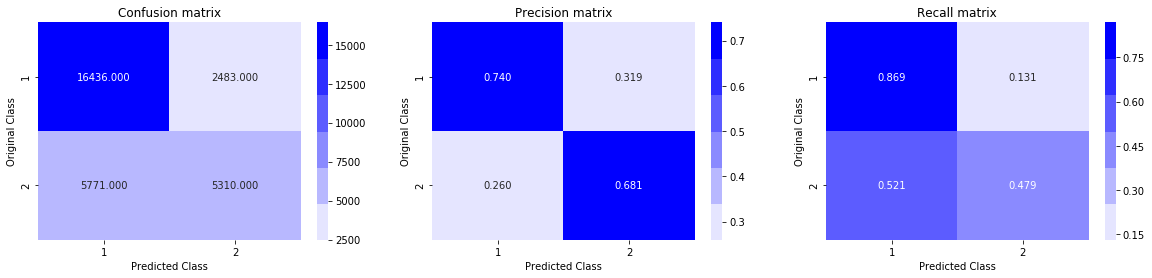

In [102]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=1,class_weight='balanced')
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test,)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=1,class_weight='balanced')
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## LINEAR SVM

For values of alpha =  1e-05 The log loss is: 0.5889715564007485
For values of alpha =  0.0001 The log loss is: 0.5000688972546586
For values of alpha =  0.001 The log loss is: 0.5311917048359449
For values of alpha =  0.01 The log loss is: 0.5548568702464831
For values of alpha =  0.1 The log loss is: 0.6026240266972311
For values of alpha =  1 The log loss is: 0.6297921036879293
For values of alpha =  10 The log loss is: 0.6438160637450993


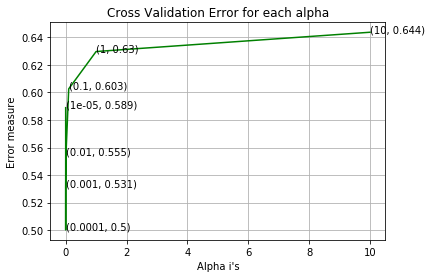

For values of best alpha =  0.0001 The train log loss is: 0.4943845113304931
For values of best alpha =  0.0001 The test log loss is: 0.5000688972546586
Total number of data points : 30000


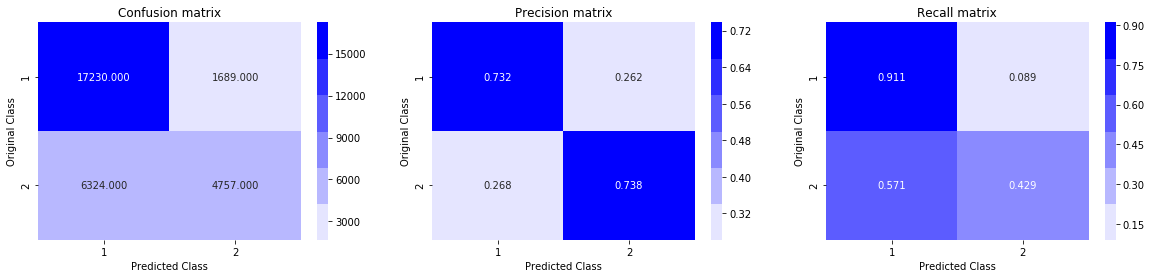

In [103]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=1,class_weight='balanced')
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=1,class_weight='balanced')
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## XGBOOST with Hyperparameter tuning

In [104]:
params = {
        'max_depth': sp_randint(1,11),
        'n_estimators' : sp_randint(5,100),
        }

model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss',n_jobs=-1)
xgb_model = RandomizedSearchCV(model, param_distributions = params,n_iter=50, scoring = 'neg_log_loss', n_jobs = -1,cv=3)
xgb_model.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000028559FC5550>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002855A01B8D0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_log_loss', verbose=0)

In [105]:
print("Model Score = ",xgb_model.best_score_)
print("Best Params = ",xgb_model.best_params_)

Model Score =  -0.3380502185387121
Best Params =  {'max_depth': 9, 'n_estimators': 95}


In [106]:
optimal_depth = 9
optimal_estimators = 95

In [107]:
clf = xgb.XGBClassifier(max_depth=optimal_depth,objective='binary:logistic',n_estimators=optimal_estimators,n_jobs=-1)
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=9, min_child_weight=1, missing=None,
       n_estimators=95, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

Log loss [Train] :  0.2025311188736861
Log loss [Test] :  0.3510581324902448


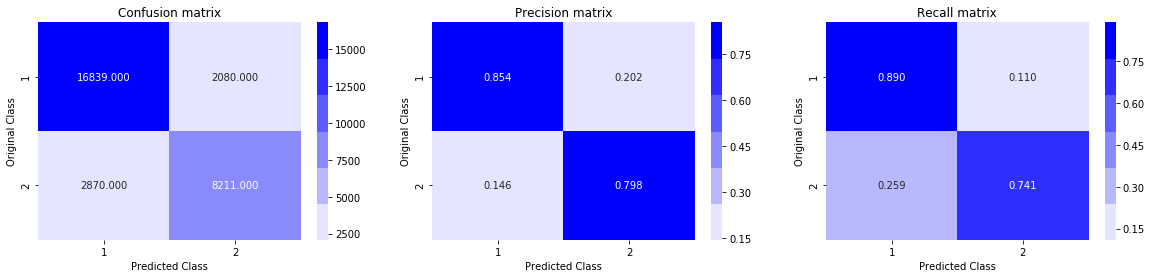

In [108]:
#log loss uses a exact probability score so we have to extract the score from the model
cal_clf = CalibratedClassifierCV(clf, method="sigmoid")
cal_clf.fit(X_train, y_train)
predict_y = cal_clf.predict_proba(X_train)

print("Log loss [Train] : ",log_loss(y_train, predict_y,  eps=1e-15))
predict_y = cal_clf.predict_proba(X_test)
print("Log loss [Test] : ",log_loss(y_test, predict_y,  eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
plot_confusion_matrix(y_test, predicted_y)

# Conclusion

In [109]:
print("*** COMPARISON between TFIDF W2VEC & TFIDF Vectorized Models ***")
print("")
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model(TF-IDF w2v)", "Train log loss", "Test log loss"]

x.add_row(["Logistic Regression", 0.5196, 0.5315])
x.add_row(["Linear SVM", 0.4943, 0.5000])
x.add_row(["XGBoost(not tuned)", 0.2025, 0.3510])
print(x)

x = PrettyTable()
x.field_names = ["Model(TF-IDF)", "Train log loss", "Test log loss"]

x.add_row(["Logistic Regression", 0.3325,0.4546])
x.add_row(["Linear SVM", 0.4485, 0.5588])
x.add_row(["XGBoost(tuned)",  0.2440, 0.3361])
print(x)

*** COMPARISON between TFIDF W2VEC & TFIDF Vectorized Models ***

+---------------------+----------------+---------------+
|  Model(TF-IDF w2v)  | Train log loss | Test log loss |
+---------------------+----------------+---------------+
| Logistic Regression |     0.5196     |     0.5315    |
|      Linear SVM     |     0.4943     |      0.5      |
|  XGBoost(not tuned) |     0.2025     |     0.351     |
+---------------------+----------------+---------------+
+---------------------+----------------+---------------+
|    Model(TF-IDF)    | Train log loss | Test log loss |
+---------------------+----------------+---------------+
| Logistic Regression |     0.3325     |     0.4546    |
|      Linear SVM     |     0.4485     |     0.5588    |
|    XGBoost(tuned)   |     0.244      |     0.3361    |
+---------------------+----------------+---------------+


### Steps Followed ::


1. Taken "nlp_features_train.csv"[Advanced features] and "df_fe_without_preprocessing_train.csc"[Basic Features] as a dataset for this model and preprocessed it by dropping the similar columns from one dataframe<br>
2. Randomly sampled 100k points and splitted it on Train and Test Data<br>
3. Vectorized question1 and question2 using TF-IDF vectorizer( seperately for train and test data ) and then convert to tfidf Word to vector model.
4. Make a RANDOM model, Linear SVM, LOGISTIC REGRESSION, XGBOOST(hyperparameter tuned) from the preprocessed dataset.<br>
5. Plotted the result log loss results of the model with pretty table.

### Results :-
- > LOG LOSS( TF-IDF ) less than LOG LOSS( TF-IDF W2VEC )
- > It seems that models performs well with TF-IDF than TF-IDF W2VEC vectorizer